# Regression Analysis: Comparing Multiple Models to Baseline

## Objective
The goal of this analysis is to evaluate the performance of various regression models in comparison to a baseline model. We aim to understand the impact of different programming languages on the dependent variable by encoding the 'repository language' column as a categorical variable using one-hot encoding. We will also explore the utility of feature selection methods to improve model accuracy.

## Methodology
1. **Data Preprocessing:**
   - One-hot encode the 'repository language' column to transform categorical language data into numerical format.
   - Standardize or normalize other continuous variables if necessary.

2. **Feature Selection (if applicable):**
   - Implement feature selection techniques to identify the most significant features for the regression analysis.
   - Evaluate the effect of feature selection on model performance.

3. **Model Implementation:**
   - Develop a baseline model for comparison using a simple linear regression approach.
   - Implement additional regression models (e.g., Ridge, Lasso, Decision Tree Regressor) to assess and compare performance.

4. **Robust Testing:**
   - Conduct the analysis across 10 different random seeds to ensure the robustness of the results.
   - Use these seeds for splitting the data, training the models, and evaluating them.

5. **Statistical Analysis:**
   - Compute confidence intervals for each model’s performance metrics to statistically infer the models' stability and reliability.
   - Use metrics such as RMSE (Root Mean Squared Error), MAE (Mean Absolute Error), and R² (Coefficient of Determination) for evaluation.

## Expected Outcomes
We anticipate identifying which regression models outperform the baseline when adjusted for various features and under different conditions. This analysis should provide insights into the predictive power of the repository languages and the effectiveness of feature selection in regression analysis.

In [1]:
# Basic utilities and data handling
import json
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm

# Machine Learning frameworks and utilities
import tensorflow as tf
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler

# Deep Learning
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

# Advanced statistics and model interpretation
import shap
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from scipy import stats

# Gradient Boosting Machines
import xgboost as xgb
from xgboost import XGBRegressor

# Data serialization
import ijson

In [2]:
df_filtered = pd.read_csv('./datasets/second_dataset.csv')

In [3]:
df_filtered.head(20)

,owner,name,stars,forks,watchers,primaryLanguage,description,diskUsageKb,pullRequests,issues,defaultBranchCommitCount,age
0,freeCodeCamp,freeCodeCamp,371122,33158,8446,TypeScript,freeCodeCamp.org's open-source codebase and cu...,372202,33649,17010,33585.0,8.65
1,EbookFoundation,free-programming-books,295895,56913,9733,NaN,:books: Freely available programming books,17038,8392,957,8386.0,9.85
2,996icu,996.ICU,267804,21532,4242,NaN,Repo for counting stars and contributing. Pres...,187799,1962,0,3195.0,4.22
3,sindresorhus,awesome,265809,26349,7549,NaN,😎 Awesome lists about all kinds of interesting...,1441,1943,331,1103.0,9.10
4,jwasham,coding-interview-university,263430,69043,8604,NaN,A complete computer science study plan to beco...,20963,902,402,2372.0,7.17
5,public-apis,public-apis,252370,28947,3897,Python,A collective list of free APIs,4948,3016,502,4527.0,7.40
6,kamranahmedse,developer-roadmap,247233,34594,6828,TypeScript,"Interactive roadmaps, guides and other educati...",2089597,2506,1334,3633.0,6.42
7,donnemartin,system-design-primer,227201,40141,6519,Python,Learn how to design large-scale systems. Prep ...,11187,493,258,329.0,6.44
8,codecrafters-io,build-your-own-x,213075,20782,4562,NaN,Master programming by recreating your favorite...,990,331,560,528.0,5.25
9,facebook,react,211912,44446,6659,JavaScript,The library for web and native user interfaces,337423,13799,12395,15900.0,10.23


In [4]:
nan_counts = df_filtered.isna().sum()
print(nan_counts)

owner                            0
name                            19
stars                            0
forks                            0
watchers                         0
primaryLanguage             252941
description                 425418
diskUsageKb                      0
pullRequests                     0
issues                           0
defaultBranchCommitCount      3853
age                            124
dtype: int64


### One Hot Encoding (Language)

In [5]:
# Selecting the top 10 languages and grouping the rest as 'Other'
top_n = 9
top_languages = df_filtered['primaryLanguage'].value_counts().nlargest(top_n).index
df_filtered['primaryLanguage'] = df_filtered['primaryLanguage'].apply(lambda x: x if x in top_languages else 'Other')

# Creating a copy for the non-one-hot encoded version
df_non_ohe = df_filtered.copy()

# One-hot encoding for 'repo_language'
ohe = OneHotEncoder(sparse_output=False)
language_encoded = ohe.fit_transform(df_filtered[['primaryLanguage']])
language_encoded_df = pd.DataFrame(language_encoded, columns=ohe.get_feature_names_out(['primaryLanguage']))

# Drop the original 'repo_language' column and concatenate the one-hot encoded language dataframe
df_ohe = df_filtered.drop('primaryLanguage', axis=1)
df_ohe = pd.concat([df_ohe, language_encoded_df], axis=1)

In [6]:
df_ohe

,owner,name,stars,forks,watchers,description,diskUsageKb,pullRequests,issues,defaultBranchCommitCount,...,primaryLanguage_C,primaryLanguage_C#,primaryLanguage_C++,primaryLanguage_HTML,primaryLanguage_Java,primaryLanguage_JavaScript,primaryLanguage_Other,primaryLanguage_PHP,primaryLanguage_Python,primaryLanguage_TypeScript
0,freeCodeCamp,freeCodeCamp,371122,33158,8446,freeCodeCamp.org's open-source codebase and cu...,372202,33649,17010,33585.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,EbookFoundation,free-programming-books,295895,56913,9733,:books: Freely available programming books,17038,8392,957,8386.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,996icu,996.ICU,267804,21532,4242,Repo for counting stars and contributing. Pres...,187799,1962,0,3195.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,sindresorhus,awesome,265809,26349,7549,😎 Awesome lists about all kinds of interesting...,1441,1943,331,1103.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,jwasham,coding-interview-university,263430,69043,8604,A complete computer science study plan to beco...,20963,902,402,2372.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274582,xutianyi1999,mutsuki,5,3,1,Socks5/HTTP proxy server,93,0,1,34.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3274583,dickwyn,cip-2021,5,0,2,My slides for Code in Place sections,13561,0,0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3274584,acend,terraform-training,5,1,4,NaN,2873,257,7,564.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3274585,suryafaktaTV,suryaTVplay,5,2,1,All Channel,683,0,0,284.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### Dropping NaN rows

In [7]:
nan_counts = df_ohe.isna().sum()
print(nan_counts)

owner                              0
name                              19
stars                              0
forks                              0
watchers                           0
description                   425418
diskUsageKb                        0
pullRequests                       0
issues                             0
defaultBranchCommitCount        3853
age                              124
primaryLanguage_C                  0
primaryLanguage_C#                 0
primaryLanguage_C++                0
primaryLanguage_HTML               0
primaryLanguage_Java               0
primaryLanguage_JavaScript         0
primaryLanguage_Other              0
primaryLanguage_PHP                0
primaryLanguage_Python             0
primaryLanguage_TypeScript         0
dtype: int64


In [8]:
df_ohe = df_ohe.dropna()

In [9]:
print(f"The number of rows in the one-hot-encoded dataset: {len(df_ohe)}")

The number of rows in the one-hot-encoded dataset: 2847669


### Plotting distribution of dataset

Series([], dtype: float64)


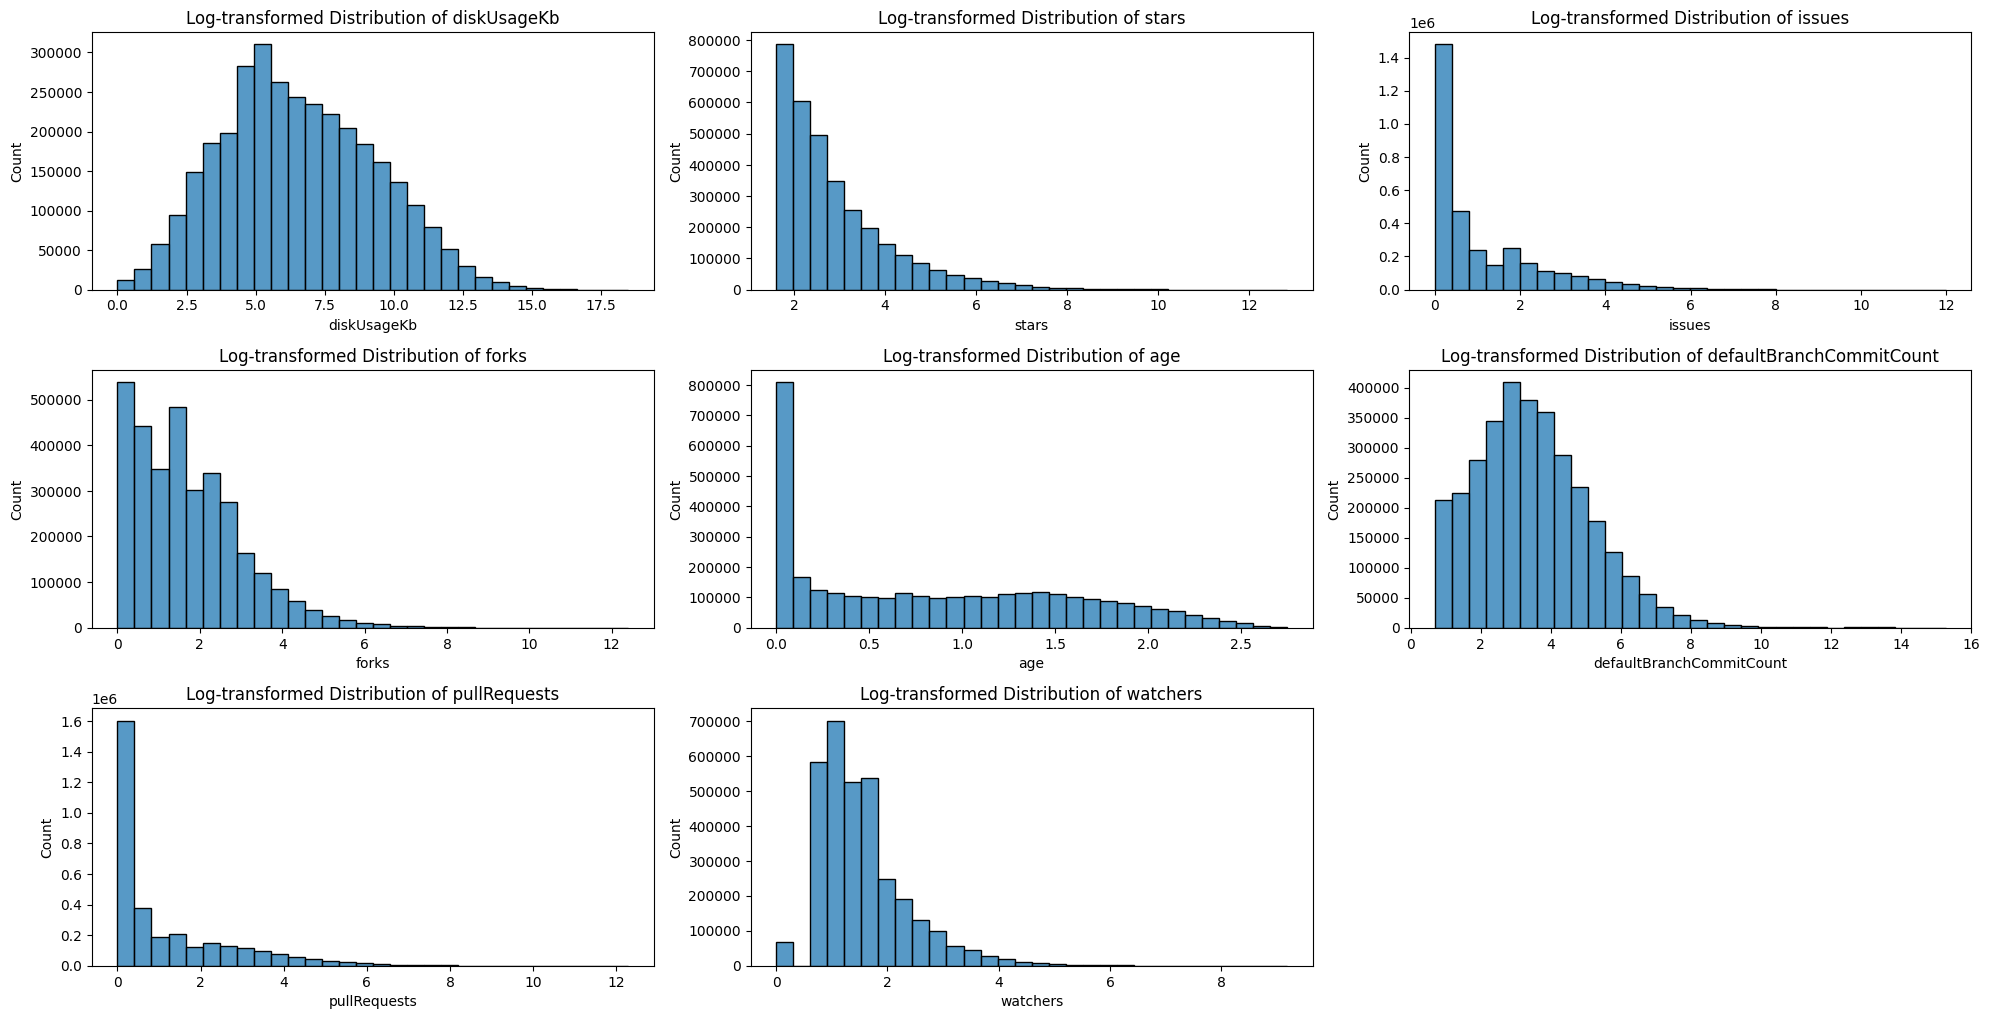

In [12]:
# Set up the matplotlib figure with a larger grid
plt.figure(figsize=(20, 20))  # Increase figure size for better visibility and fit

numerical_columns = ['diskUsageKb', 'stars', 'issues', 'forks', 'age', 'defaultBranchCommitCount', 'pullRequests', 'watchers']
categorical_columns_prefix = 'primaryLanguage_'

# Plotting the numerical columns after applying log1p transformation
for i, column in enumerate(numerical_columns, 1):
    transformed_column = np.log1p(df_filtered[column])  # Applying log1p transformation
    plt.subplot(6, 3, i)  # Adjusting subplot grid to 6 rows and 3 columns
    sns.histplot(transformed_column, kde=False, bins=30)
    plt.title(f'Log-transformed Distribution of {column}')

plt.tight_layout()
plt.show()

<Figure size 1500x1000 with 0 Axes>

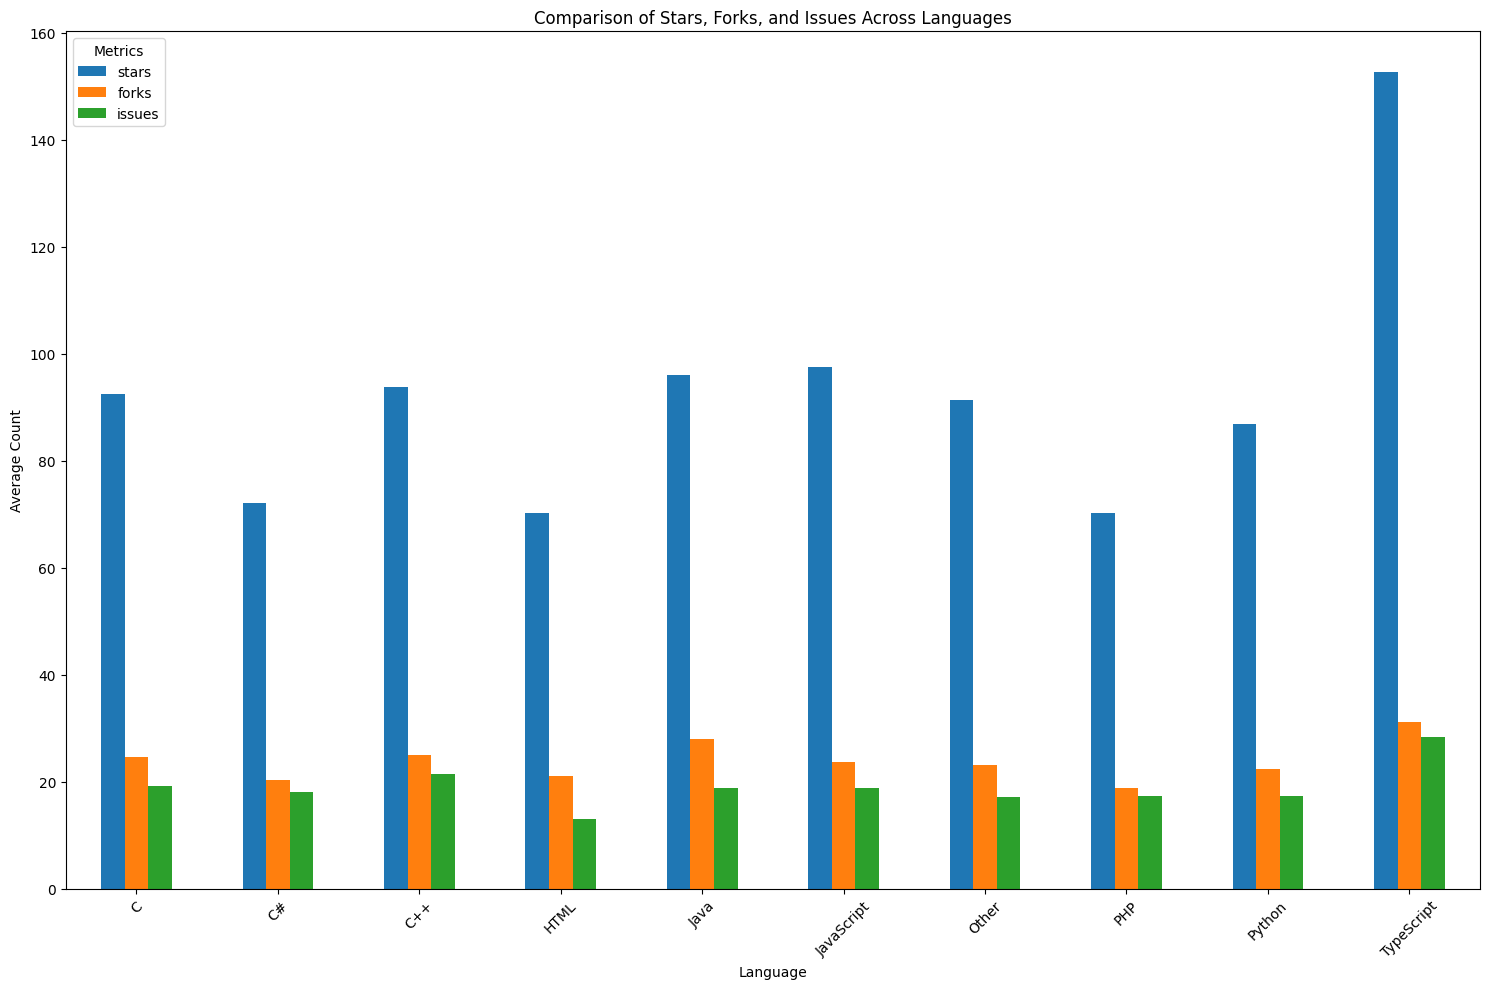

In [22]:
# Define your one-hot columns and the columns of interest
one_hot_columns = [col for col in df_ohe.columns if col.startswith('primaryLanguage_')]
interest_columns = ['stars', 'forks', 'issues']

# Create a new DataFrame to hold aggregated data
language_comparison = pd.DataFrame()

# Aggregate the data for each language
for language in one_hot_columns:
    # Mask to filter rows where the language is present
    mask = df_ohe[language] == 1
    for col in interest_columns:
        # Compute the mean of each column of interest for the language
        # Adjust aggregation method if necessary (mean, median, sum)
        language_comparison.loc[language, col] = df_ohe.loc[mask, col].mean()

# Reset index to turn the indices into a proper column
language_comparison.reset_index(inplace=True)
# Rename 'index' to 'Language' and strip the prefix from language names
language_comparison['Language'] = language_comparison['index'].str.replace('primaryLanguage_', '')
language_comparison.drop('index', axis=1, inplace=True)

# Plotting
plt.figure(figsize=(15, 10))
language_comparison.set_index('Language').plot(kind='bar', figsize=(15, 10))
plt.title('Comparison of Stars, Forks, and Issues Across Languages')
plt.ylabel('Average Count')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

## Pearson's Correlation Coefficient (distributed data)

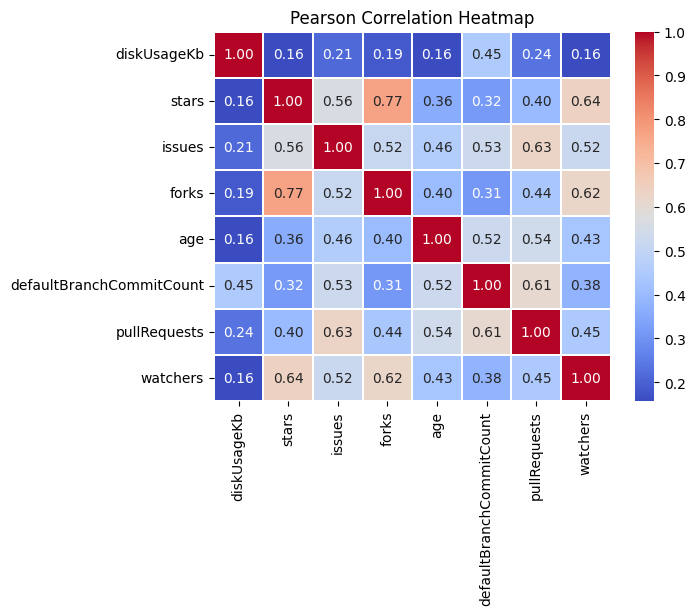

In [24]:
# Select the input features
input_features = df_filtered[numerical_columns].apply(np.log1p)
pearson_correlation = input_features.corr(method='pearson')

sns.heatmap(pearson_correlation, 
            annot=True,      # Annotate each cell with the numeric value
            cmap='coolwarm', # Color map to use
            fmt=".2f",       # Format for the annotations
            linewidths=.05)  # Space between cells

plt.title('Pearson Correlation Heatmap')
plt.show()

## Spearman's Rho (non-distributed data)

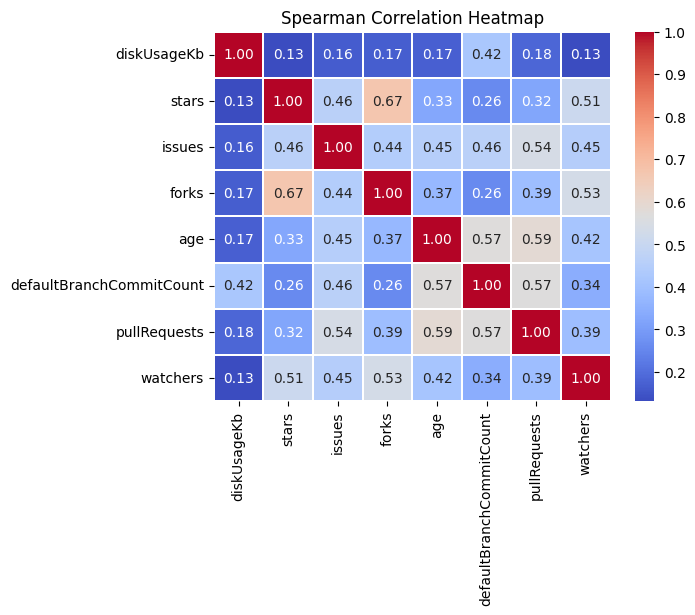

In [44]:
# Select the input features
input_features = df_filtered[numerical_columns].apply(np.log1p)

# Using Spearman's correlation instead of Pearson's
spearman_correlation = input_features.corr(method='spearman')

# Plotting the heatmap using Spearman's correlation
sns.heatmap(spearman_correlation, 
            annot=True,      # Annotate each cell with the numeric value
            cmap='coolwarm', # Color map to use
            fmt=".2f",       # Format for the annotations
            linewidths=.05)  # Space between cells

plt.title('Spearman Correlation Heatmap')
plt.show()

## Feature Selection

In [ ]:
def feature_selection(X, y, target_name, model_params=None, classification=False):
    if model_params is None:
        model_params = {'n_estimators': 50, 'random_state': 42} # n_estimators = 100 for other instances, set to 50 for target encoding
    if classification:
        model = RandomForestClassifier(**model_params)
    else:
        model = RandomForestRegressor(**model_params)
    model.fit(X, y)
    feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    print(f"Feature importances for predicting {target_name}:\n{feature_importances}\n")
    feature_importances.plot(kind='bar')
    plt.title(f"Feature Importances for {target_name}")
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.show()
    selector = SelectFromModel(model, prefit=True)
    selected_features = X.columns[selector.get_support()]
    print(f"Selected features for predicting {target_name}:", selected_features)

In [ ]:
# Assuming 'df' is your DataFrame and it includes 'stars', 'forks', 'issues', and other feature columns
X = df_filtered.drop(['stars', 'forks', 'issues', 'owner', 'name', 'description'], axis=1)  # Exclude the target variables from the features

# Define targets separately
targets = ['stars', 'forks', 'issues']

In [ ]:
# Iterate over each target, selecting features
for target in targets:
    print(f"Processing feature selection for: {target}")
    y = df_filtered[target]  # Set the current target
    feature_selection(X, y, target_name=target)

## Scatterplots + p values

* Following feature selection, let's observe our chosen input features against our target metrics.

* **Target features**: stars, forks, issues

In [72]:
# Define a function to perform Spearman's correlation and add p-value to the plot
def annotate_corr(x, y, ax):
    corr, p_value = stats.spearmanr(df_filtered[x], df_filtered[y])
    annotation = f'rho={corr:.2f}, p={p_value:.3g}'
    ax.annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
                verticalalignment='top')

### Stars

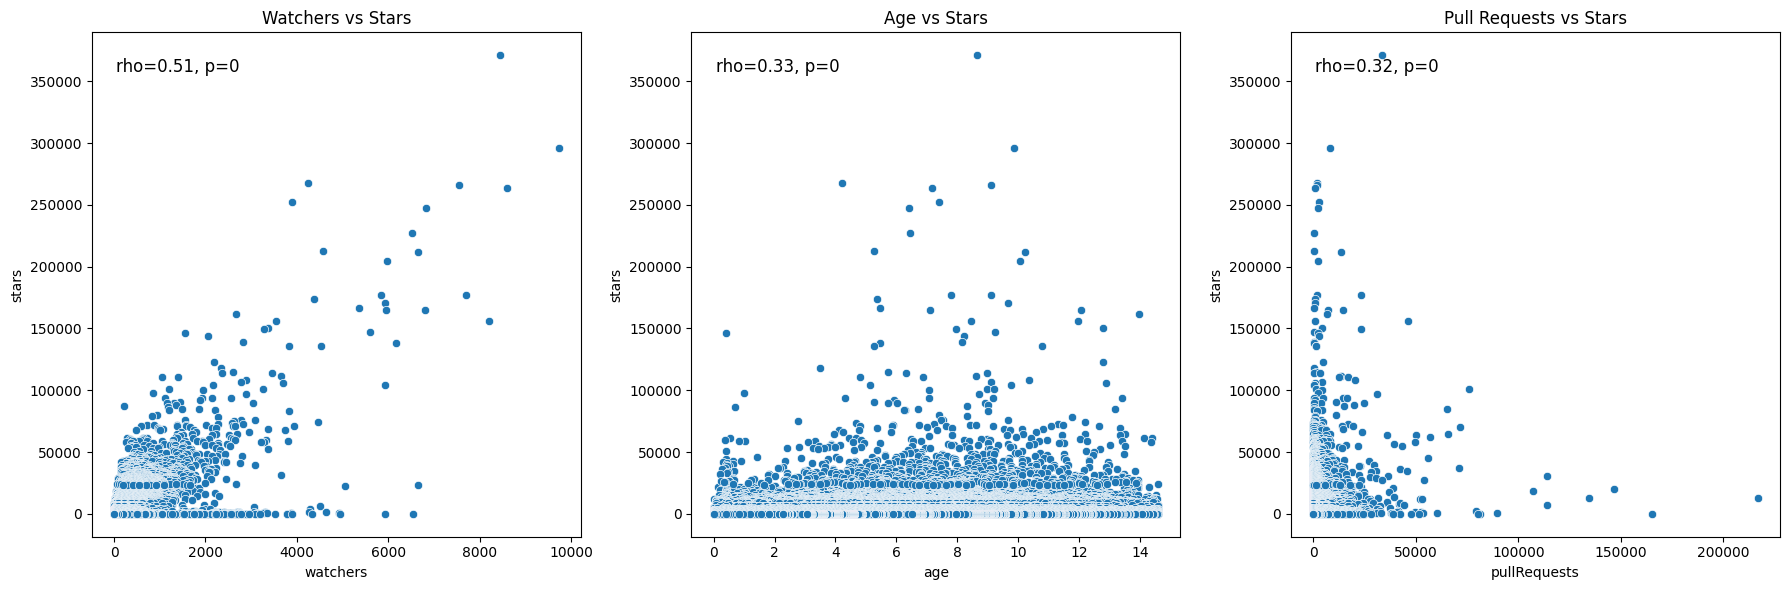

In [73]:
# Create scatter plots and annotate them with Spearman's correlation coefficient and p-value
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(data=df_filtered, x='watchers', y='stars', ax=ax[0])
annotate_corr('watchers', 'stars', ax[0])
ax[0].set_title('Watchers vs Stars')

sns.scatterplot(data=df_filtered, x='age', y='stars', ax=ax[1])
annotate_corr('age', 'stars', ax[1])
ax[1].set_title('Age vs Stars')

sns.scatterplot(data=df_filtered, x='pullRequests', y='stars', ax=ax[2])
annotate_corr('pullRequests', 'stars', ax[2])
ax[2].set_title('Pull Requests vs Stars')
plt.tight_layout()
plt.show()

### Forks

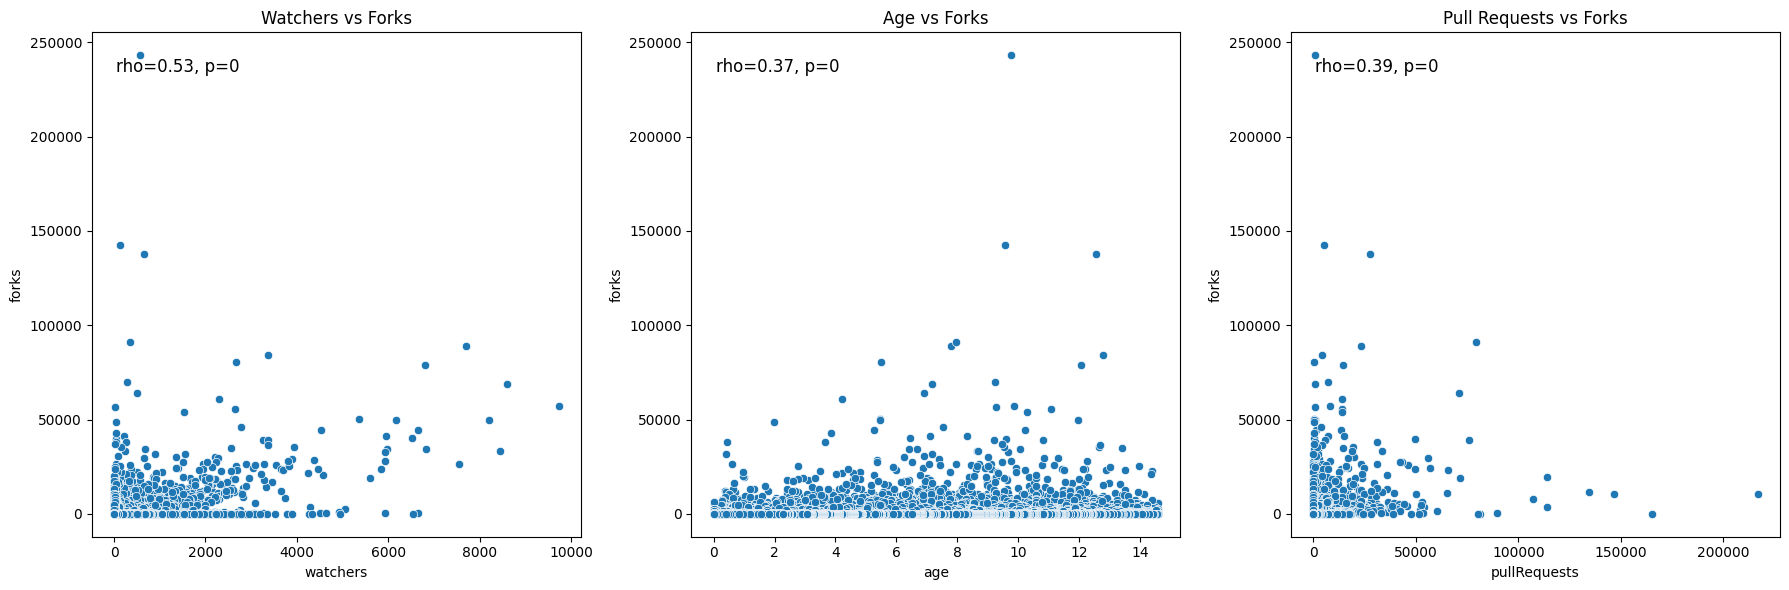

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(data=df_filtered, x='watchers', y='forks', ax=ax[0])
annotate_corr('watchers', 'forks', ax[0])
ax[0].set_title('Watchers vs Forks')

sns.scatterplot(data=df_filtered, x='age', y='forks', ax=ax[1])
annotate_corr('age', 'forks', ax[1])
ax[1].set_title('Age vs Forks')

sns.scatterplot(data=df_filtered, x='pullRequests', y='forks', ax=ax[2])
annotate_corr('pullRequests', 'forks', ax[2])
ax[2].set_title('Pull Requests vs Forks')
plt.tight_layout()
plt.show()

### Issues

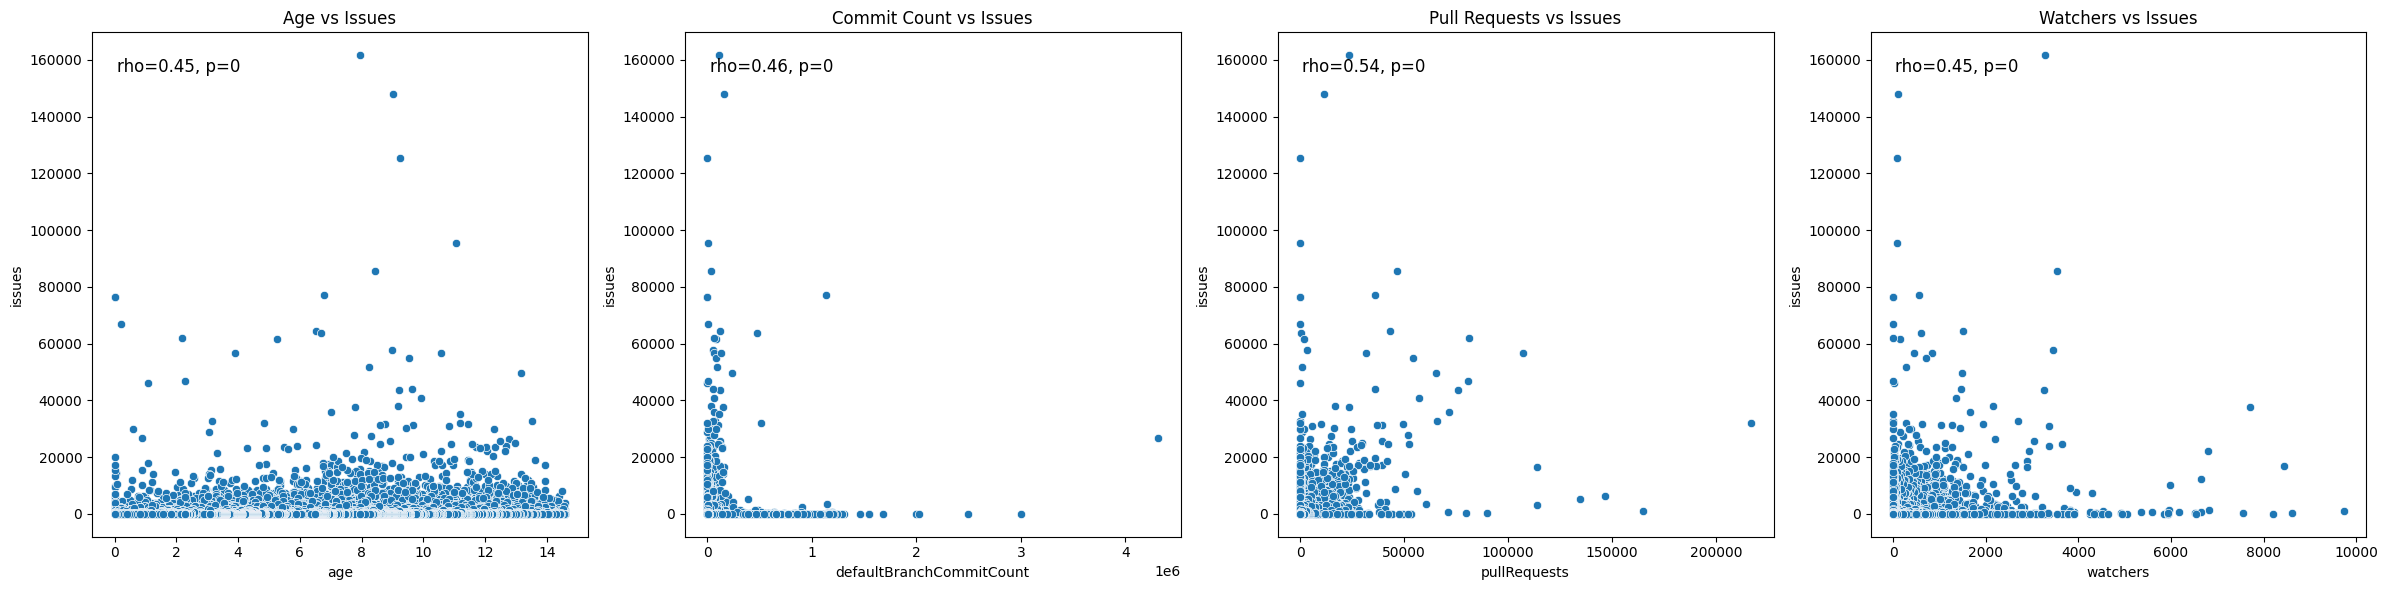

In [75]:
fig, ax = plt.subplots(1, 4, figsize=(24, 6))
sns.scatterplot(data=df_filtered, x='age', y='issues', ax=ax[0])
annotate_corr('age', 'issues', ax[0])
ax[0].set_title('Age vs Issues')

sns.scatterplot(data=df_filtered, x='defaultBranchCommitCount', y='issues', ax=ax[1])
annotate_corr('defaultBranchCommitCount', 'issues', ax[1])
ax[1].set_title('Commit Count vs Issues')

sns.scatterplot(data=df_filtered, x='pullRequests', y='issues', ax=ax[2])
annotate_corr('pullRequests', 'issues', ax[2])
ax[2].set_title('Pull Requests vs Issues')

sns.scatterplot(data=df_filtered, x='watchers', y='issues', ax=ax[3])
annotate_corr('watchers', 'issues', ax[3])
ax[3].set_title('Watchers vs Issues')
plt.tight_layout()
plt.show()

#### Package Imports for Regression Analysis

#### Linear Regression Function

In [12]:
def train_evaluate_explain(X, y, test_size=0.2, random_state=42):
    with PdfPages('issues-analysis-LF.pdf') as pdf:
        print("\nAverage of y:", y.mean())
        
        # Splitting the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        # Initialize and train the model
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        # Model details
        print("Model Intercept:", model.intercept_)
        model_details = f"Model Intercept: {model.intercept_:.4f}\n"
        for name, coef in zip(X_train.columns, model.coef_):
            print(f"{name}: {coef}")
            model_details += f"{name}: {coef:.4f}\n"
            
        # Function to evaluate model performance
        def evaluate_performance(y_true, y_pred, set_name="Test"):
            mse = mean_squared_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            mae = mean_absolute_error(y_true, y_pred)
            performance_summary = (f'{set_name} Set - MSE: {mse:.4f}, '
                                   f'R^2: {r2:.4f}, MAE: {mae:.4f}\n')
            print(performance_summary)
            return performance_summary
        
        # Evaluate model performance
        y_pred_test = model.predict(X_test)
        performance_summary = evaluate_performance(y_test, y_pred_test, "Test")
        
        # Combine model details with performance summary
        full_summary = model_details + "\n" + performance_summary
        
        # Create a figure with the full summary
        fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figure size as needed
        ax.axis('off')
        ax.text(0.5, 0.5, full_summary, ha='center', va='center', fontsize=10, family='monospace')
        pdf.savefig(fig)
        plt.close()
        
        # SHAP Analysis
        explainer = shap.Explainer(model, X_train)
        shap_values = explainer(X_test)
        
        # Save SHAP summary plot (bar)
        shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
        pdf.savefig()
        plt.close()
        
        
        # Save SHAP summary plot
        shap.summary_plot(shap_values, X_test, show=False)
        pdf.savefig()
        plt.close()
    
        # Feature Importance Plot
        shap.plots.bar(shap_values, show=False)
        pdf.savefig()
        plt.close()

        # Waterfall plot for the first prediction
        shap.plots.waterfall(shap_values[0], max_display=10, show=False)
        pdf.savefig()
        plt.close()

        # Scatter plot for the first feature
        shap.plots.scatter(shap_values[:, X_train.columns[0]], color=shap_values, show=False)
        pdf.savefig()
        plt.close()
        

        # Dependence plots for all features
        for feature in X_train.columns:
            shap.dependence_plot(feature, shap_values.values, X_test, interaction_index=None, show=False)
            pdf.savefig()
            plt.close()

## Insight Comparison
* We need to observe if our insights hold from dataset 1, using overlapping features.
* If our insights hold, then state that; otherwise, note differences and provide intuition as to why it occurs.

We test this by using overlapping input features:
1. age
2. size
3. one-hot-encoded languages

#### Stars

In [10]:
X = df_ohe.copy()
columns_to_exclude = ['owner', 'name', 'description', 'forks', \
                     'stars', 'issues']
extra_cols = ['watchers','pullRequests', 'defaultBranchCommitCount']
X_2 = X.drop(columns=columns_to_exclude+extra_cols)
X_2 = X_2.loc[X_2['age'] >=0]
y = X[X['age'] >=0]['stars']
y_stars = y.apply(np.log1p)

if 'age' in X_2.columns and 'diskUsageKb' in X_2.columns:
    # Apply np.log1p to 'age' and 'diskUsageKb' columns
    X_2['age'] = np.log1p(X_2['age'])
    X_2['diskUsageKb'] = np.log1p(X_2['diskUsageKb'])
else:
    print("The columns 'age' and/or 'diskUsageKb' are not present in X_2.")

    
# OHE - Drop one to avoid multi-collinearity
star_baseline = X_2.drop(columns=['primaryLanguage_Other'])
star_baseline

,diskUsageKb,age,primaryLanguage_C,primaryLanguage_C#,primaryLanguage_C++,primaryLanguage_HTML,primaryLanguage_Java,primaryLanguage_JavaScript,primaryLanguage_PHP,primaryLanguage_Python,primaryLanguage_TypeScript
0,12.827195,2.266958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9.743260,2.384165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.143133,1.652497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.273786,2.312535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.950562,2.100469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3274581,4.812184,1.141033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3274582,4.543295,1.150572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3274583,9.515027,0.019803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3274585,6.527958,1.036737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Forks

In [11]:
X = df_ohe.copy()
columns_to_exclude = ['owner', 'name', 'description', 'forks', \
                     'stars', 'issues']
extra_cols = ['watchers','pullRequests', 'defaultBranchCommitCount']
X_2 = X.drop(columns=columns_to_exclude+extra_cols)
X_2 = X_2.loc[X_2['age'] >=0]
y = X[X['age'] >=0]['forks']
y_forks = y.apply(np.log1p)

if 'age' in X_2.columns and 'diskUsageKb' in X_2.columns:
    # Apply np.log1p to 'age' and 'diskUsageKb' columns
    X_2['age'] = np.log1p(X_2['age'])
    X_2['diskUsageKb'] = np.log1p(X_2['diskUsageKb'])
else:
    print("The columns 'age' and/or 'diskUsageKb' are not present in X_2.")

    
# OHE - Drop one to avoid multi-collinearity
fork_baseline = X_2.drop(columns=['primaryLanguage_Other'])
fork_baseline

,diskUsageKb,age,primaryLanguage_C,primaryLanguage_C#,primaryLanguage_C++,primaryLanguage_HTML,primaryLanguage_Java,primaryLanguage_JavaScript,primaryLanguage_PHP,primaryLanguage_Python,primaryLanguage_TypeScript
0,12.827195,2.266958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9.743260,2.384165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.143133,1.652497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.273786,2.312535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.950562,2.100469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3274581,4.812184,1.141033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3274582,4.543295,1.150572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3274583,9.515027,0.019803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3274585,6.527958,1.036737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Issues

In [12]:
X = df_ohe.copy()
columns_to_exclude = ['owner', 'name', 'description', 'forks', \
                     'stars', 'issues']
extra_cols = ['watchers','pullRequests', 'defaultBranchCommitCount']
X_2 = X.drop(columns=columns_to_exclude+extra_cols)
X_2 = X_2.loc[X_2['age'] >=0]
y = X[X['age'] >=0]['issues']
y_issues = y.apply(np.log1p)

if 'age' in X_2.columns and 'diskUsageKb' in X_2.columns:
    # Apply np.log1p to 'age' and 'diskUsageKb' columns
    X_2['age'] = np.log1p(X_2['age'])
    X_2['diskUsageKb'] = np.log1p(X_2['diskUsageKb'])
else:
    print("The columns 'age' and/or 'diskUsageKb' are not present in X_2.")

    
# OHE - Drop one to avoid multi-collinearity
issue_baseline = X_2.drop(columns=['primaryLanguage_Other'])
issue_baseline

,diskUsageKb,age,primaryLanguage_C,primaryLanguage_C#,primaryLanguage_C++,primaryLanguage_HTML,primaryLanguage_Java,primaryLanguage_JavaScript,primaryLanguage_PHP,primaryLanguage_Python,primaryLanguage_TypeScript
0,12.827195,2.266958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9.743260,2.384165,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12.143133,1.652497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.273786,2.312535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.950562,2.100469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3274581,4.812184,1.141033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3274582,4.543295,1.150572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3274583,9.515027,0.019803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3274585,6.527958,1.036737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Linear Regression

Stars

In [32]:
train_evaluate_explain(star_baseline,y_stars)


Average of y: 2.977039352750801
Model Intercept: 2.1340868044584123
diskUsageKb: 0.0537106891726796
age: 0.5853310809694223
primaryLanguage_C: -0.018019777927668835
primaryLanguage_C#: -0.08024282782162863
primaryLanguage_C++: -0.03130482767795261
primaryLanguage_HTML: -0.25681082861834387
primaryLanguage_Java: -0.039220040794910004
primaryLanguage_JavaScript: -0.05106069772171072
primaryLanguage_PHP: -0.1994720505503859
primaryLanguage_Python: 0.04523441263888831
primaryLanguage_TypeScript: 0.03602047905271071
Test Set - MSE: 1.3205, R^2: 0.1446, MAE: 0.8654



LinearExplainer explainer: 567958it [00:12, 3962.34it/s]                                                               


Forks

In [36]:
train_evaluate_explain(fork_baseline,y_forks)


Average of y: 1.7487635665082613
Model Intercept: 0.6653116837052286
diskUsageKb: 0.06523552623819223
age: 0.6946433744975757
primaryLanguage_C: 0.11220447860359847
primaryLanguage_C#: 0.03780206469410337
primaryLanguage_C++: 0.09823799490600943
primaryLanguage_HTML: -0.006086189171167669
primaryLanguage_Java: 0.3087441679865766
primaryLanguage_JavaScript: -0.00871357415136017
primaryLanguage_PHP: 0.026625294754164155
primaryLanguage_Python: 0.14037021518708473
primaryLanguage_TypeScript: -0.16890142114372036
Test Set - MSE: 1.4495, R^2: 0.1818, MAE: 0.9408



LinearExplainer explainer: 567958it [00:11, 4541.44it/s]                                                               


Issues

In [37]:
train_evaluate_explain(issue_baseline,y_issues)


Average of y: 1.1259304838976931
Model Intercept: -0.2077472163628551
diskUsageKb: 0.0829882079846125
age: 0.8325217550424285
primaryLanguage_C: -0.11114113154168401
primaryLanguage_C#: 0.0454327237513124
primaryLanguage_C++: -0.0026440546316519598
primaryLanguage_HTML: -0.16765258511478845
primaryLanguage_Java: 0.02973283685508571
primaryLanguage_JavaScript: 0.10481837644085397
primaryLanguage_PHP: 0.1405723798297759
primaryLanguage_Python: 0.16674415536199122
primaryLanguage_TypeScript: 0.40481817605689635
Test Set - MSE: 1.4948, R^2: 0.2405, MAE: 0.9288



LinearExplainer explainer: 567958it [00:11, 4243.02it/s]                                                               


## Model Robust Framework Pipeline

### Template Framework

In [13]:
def model_evaluation_framework(model, X, y, seeds, test_size=0.2, model_type='linear', pdf_path='model_analysis_regression.pdf'):
    results = {
        'MSE': [],
        'RMSE': [],
        'MAE': [],
        'R_squared': [],
        'feature_importances': []
    }

    feature_names = X.columns.tolist()
    all_shap_values = []

    with PdfPages(pdf_path) as pdf:
        for seed in tqdm(seeds):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
            
            # Fit the model
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Collecting metrics
            results['MSE'].append(mean_squared_error(y_test, y_pred))
            results['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            results['MAE'].append(mean_absolute_error(y_test, y_pred))
            results['R_squared'].append(r2_score(y_test, y_pred))

            # Feature importances if applicable
            if hasattr(model, 'feature_importances_'):
                results['feature_importances'].append(model.feature_importances_)
            elif hasattr(model, 'coef_'):
                results['feature_importances'].append(model.coef_[0])

            # SHAP analysis depending on model type
            if model_type in ['linear', 'ridge', 'lasso']:
                explainer = shap.LinearExplainer(model, X_train)
            elif model_type in ['decision_tree', 'xgboost', 'random_forest']:
                explainer = shap.TreeExplainer(model)
            else:
                continue  # Skip SHAP for unsupported model types
            
            shap_values = explainer.shap_values(X_train)
            all_shap_values.append(shap_values)

        # Calculate mean SHAP values and plot if applicable
        if all_shap_values:
            mean_shap_values = np.mean(all_shap_values, axis=0)
            fig, ax = plt.subplots()
            shap.summary_plot(mean_shap_values, X_train, plot_type="bar", show=False)
            pdf.savefig(fig)
            plt.close(fig)

        # Calculate mean and confidence intervals for metrics and feature importances
        summary = {key: {'mean': np.mean(val), '95%_CI': (np.percentile(val, 2.5), np.percentile(val, 97.5))}
                   for key, val in results.items() if val}

        # Include performance metrics and feature importance CIs in the PDF
        fig, ax = plt.subplots()
        textstr = '\n'.join([
            f'{key}: Mean={summary[key]["mean"]:.4f}, 95% CI=({summary[key]["95%_CI"][0]:.4f}, {summary[key]["95%_CI"][1]:.4f})'
            for key in ['MSE', 'RMSE', 'MAE', 'R_squared'] if key in summary
        ])
        ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='center', horizontalalignment='center')
        ax.axis('off')
        pdf.savefig(fig)
        plt.close(fig)
        
        # Early exit, linear regression has problems plotting CI intervals; time restraint
        if model_type == 'linear':
            return summary
        
        if 'feature_importances' in summary:
            feature_importance_means = np.mean(results['feature_importances'], axis=0)
            feature_importance_cis = np.percentile(results['feature_importances'], [2.5, 97.5], axis=0)
            # Adjust the calculation for error bars
            error_bars = np.abs(feature_importance_cis - feature_importance_means[:, None])

            fig, ax = plt.subplots(figsize=(18, 12))
            ax.bar(feature_names, feature_importance_means, yerr=error_bars, capsize=5)
            ax.set_ylabel('Feature Importance')
            ax.set_title('Feature Importance with 95% CI')
            ax.set_xticks(range(len(feature_names)))
            ax.set_xticklabels(feature_names, rotation=90)
            pdf.savefig(fig)
            plt.close(fig)

    return summary

### Baseline

In [15]:
def model_baseline_framework(X, y, seeds, test_size=0.2, pdf_path='[2nd-dataset]baseline_evaluation_stars.pdf'):
    results = {
        'MSE': [],
        'RMSE': [],
        'MAE': [],
        'R_squared': []
    }

    with PdfPages(pdf_path) as pdf:
        for seed in seeds:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

            # Baseline predictions - use the median value of y_train for all predictions
            median_y_train = y_train.median()
            baseline_predictions = np.full(shape=y_test.shape, fill_value=median_y_train)

            # Collecting metrics
            mse = mean_squared_error(y_test, baseline_predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, baseline_predictions)
            r_squared = r2_score(y_test, baseline_predictions)

            results['MSE'].append(mse)
            results['RMSE'].append(rmse)
            results['MAE'].append(mae)
            results['R_squared'].append(r_squared)

        # Calculate mean and confidence intervals for metrics
        summary = {key: {'mean': np.mean(val), '95%_CI': (np.percentile(val, 2.5), np.percentile(val, 97.5))}
                   for key, val in results.items()}

        # Include performance metrics in the PDF
        fig, ax = plt.subplots()
        textstr = '\n'.join([
            f'{key}: Mean={summary[key]["mean"]:.4f}, 95% CI=({summary[key]["95%_CI"][0]:.4f}, {summary[key]["95%_CI"][1]:.4f})'
            for key in summary
        ])
        ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='center', horizontalalignment='center')
        ax.axis('off')
        pdf.savefig(fig)
        plt.close(fig)

        # Simulated SHAP summary plot (this would normally be model-specific and not applicable directly to a baseline model)
        # Here, we assume an equal contribution for simplicity
        shap_values = np.ones(X_train.shape) * 0.1  # Simulating SHAP values
        shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
        fig = plt.gcf()  # Get the current figure
        pdf.savefig(fig)
        plt.close(fig)

    return summary

In [ ]:
seeds = np.random.randint(20, 33, 10)
summary = model_baseline_framework(star_baseline, y_stars, seeds)
print(summary)

In [24]:
seeds = np.random.randint(20, 33, 10)
summary = model_baseline_framework(fork_baseline, y_forks, seeds)
print(summary)

{'MSE': {'mean': 1.7985734338756019, '95%_CI': (1.7947516077854955, 1.8020836959620101)}, 'RMSE': {'mean': 1.3411088001415106, '95%_CI': (1.3396833678315558, 1.3424170849683434)}, 'MAE': {'mean': 1.0266154177524796, '95%_CI': (1.0257517690149613, 1.027631785406802)}, 'R_squared': {'mean': -0.010792273349407466, '95%_CI': (-0.011031223582589789, -0.010626756519867353)}}


In [25]:
seeds = np.random.randint(20, 33, 10)
summary = model_baseline_framework(issue_baseline, y_issues, seeds)
print(summary)

{'MSE': {'mean': 2.1650288824752906, '95%_CI': (2.1567842104120665, 2.171622588613618)}, 'RMSE': {'mean': 1.4714026332862502, '95%_CI': (1.4685993585127288, 1.4736426258131983)}, 'MAE': {'mean': 1.031252354610573, '95%_CI': (1.029481792288343, 1.0322976433484603)}, 'R_squared': {'mean': -0.09531740005577802, '95%_CI': (-0.09593386740692011, -0.09475564411736587)}}


### Linear Regression

Stars

In [14]:
model = LinearRegression()
seeds = np.random.randint(20, 33, 10)
summary = model_evaluation_framework(model, star_baseline, y_stars, seeds,\
                                    model_type='linear',pdf_path=f'[2nd-dataset]LR_stars_overlap.pdf')
print(summary)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]


{'MSE': {'mean': 1.3275685591824533, '95%_CI': (1.3233283470832506, 1.3331784547844798)}, 'RMSE': {'mean': 1.1522007892364408, '95%_CI': (1.1503600938564682, 1.1546333637447779)}, 'MAE': {'mean': 0.8673232160557328, '95%_CI': (0.8660202313079667, 0.868859721340279)}, 'R_squared': {'mean': 0.14533921406209532, '95%_CI': (0.14411728111525507, 0.14699944687959812)}, 'feature_importances': {'mean': 0.05367990878734051, '95%_CI': (0.05358446448793268, 0.05381225917471403)}}


Forks

In [15]:
model = LinearRegression()
seeds = np.random.randint(20, 33, 10)
summary = model_evaluation_framework(model, fork_baseline, y_forks, seeds,\
                                    model_type='linear',pdf_path=f'[2nd-dataset]LR_forks_overlap.pdf')
print(summary)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


{'MSE': {'mean': 1.4549220951357182, '95%_CI': (1.4504566588540928, 1.460307517158182)}, 'RMSE': {'mean': 1.2062005204474393, '95%_CI': (1.2043490602205378, 1.2084318421649531)}, 'MAE': {'mean': 0.9423978475988453, '95%_CI': (0.9407555639183052, 0.9437209695064367)}, 'R_squared': {'mean': 0.18352148876808355, '95%_CI': (0.18118272180852577, 0.18528012285046003)}, 'feature_importances': {'mean': 0.06519179957369936, '95%_CI': (0.06512692606592971, 0.06535249157421649)}}


Issues

In [16]:
model = LinearRegression()
seeds = np.random.randint(20, 33, 10)
summary = model_evaluation_framework(model, issue_baseline, y_issues, seeds,\
                                    model_type='linear',pdf_path=f'[2nd-dataset]LR_issues_overlap.pdf')
print(summary)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


{'MSE': {'mean': 1.4954026715900974, '95%_CI': (1.492305267099143, 1.499139392104553)}, 'RMSE': {'mean': 1.222866211682223, '95%_CI': (1.221599466766177, 1.2243934537954981)}, 'MAE': {'mean': 0.9284717367624019, '95%_CI': (0.9276959994864078, 0.9294165579189204)}, 'R_squared': {'mean': 0.2422065651719481, '95%_CI': (0.2418762807160489, 0.2428187689966695)}, 'feature_importances': {'mean': 0.0827471954341485, '95%_CI': (0.08262138111962583, 0.08290358276094632)}}


### XGBoost (best performing model)

In [24]:
def train_evaluate_xgb_regression(features, targets, seeds, pdf_path):
    metrics = []
    
    # Initialize SHAP Explainer and values storage
    explainer, shap_values_list = None, []

    # Loop over seeds
    for seed in tqdm(seeds):
        X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=seed)
        model = xgb.XGBRegressor(random_state=seed)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Append metrics
        metrics.append({
            'MSE': mean_squared_error(y_test, y_pred),
            'MAE': mean_absolute_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred)
        })

        # Initialize SHAP Explainer once
        if explainer is None:
            explainer = shap.Explainer(model)
        shap_values = explainer(X_test)
        shap_values_list.append(shap_values)

    # Calculate average and confidence intervals for metrics using percentiles
    metric_summary = {}
    for key in metrics[0].keys():
        all_values = [m[key] for m in metrics]
        metric_summary[key] = {
            'mean': np.mean(all_values),
            '95% CI': np.percentile(all_values, [2.5, 97.5])
        }
    
    # Save to PDF
    with PdfPages(pdf_path) as pdf:
        # Metrics plot on its own page
        fig, ax = plt.subplots()
        for metric, values in metric_summary.items():
            ax.bar(metric, values['mean'], yerr=values['95% CI'], capsize=5)
            ax.text(metric, values['mean'], f'{values["mean"]:.2f} ± {values["95% CI"]:.2f}',
                    ha='center', va='bottom')
        ax.set_ylabel('Score')
        ax.set_title('Average Performance Metrics with Confidence Intervals')
        pdf.savefig(fig)
        plt.close(fig)

        # SHAP summary plot on its own page
        fig = plt.figure()
        shap.summary_plot(shap_values_list[-1], X_test, show=False)
        pdf.savefig(fig)
        plt.close(fig)

        # SHAP bar plot on its own page
        fig = plt.figure()
        shap.plots.bar(shap_values_list[-1], show=False)
        pdf.savefig(fig)
        plt.close(fig)

    return metric_summary

In [31]:
def xgb_evaluation_framework(X, y, seeds, test_size=0.2, model_type='linear', pdf_path='model_analysis_regression.pdf'):
    results = {
        'MSE': [],
        'RMSE': [],
        'MAE': [],
        'R_squared': [],
    }

    feature_names = X.columns.tolist()
    all_shap_values = []

    with PdfPages(pdf_path) as pdf:
        for seed in tqdm(seeds):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
            
            # Fit the model
            model = xgb.XGBRegressor(random_state=seed)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Collecting metrics
            results['MSE'].append(mean_squared_error(y_test, y_pred))
            results['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            results['MAE'].append(mean_absolute_error(y_test, y_pred))
            results['R_squared'].append(r2_score(y_test, y_pred))

            # SHAP analysis depending on model type
            if model_type in ['linear', 'ridge', 'lasso']:
                explainer = shap.LinearExplainer(model, X_train)
            elif model_type in ['decision_tree', 'xgboost', 'random_forest']:
                explainer = shap.TreeExplainer(model)
            else:
                continue  # Skip SHAP for unsupported model types
            
            shap_values = explainer.shap_values(X_train)
            all_shap_values.append(shap_values)

        # Calculate mean SHAP values and plot if applicable
        if all_shap_values:
            mean_shap_values = np.mean(all_shap_values, axis=0)
            fig, ax = plt.subplots()
            shap.summary_plot(mean_shap_values, X_train, plot_type="bar", show=False)
            pdf.savefig(fig)
            plt.close(fig)

        # Calculate mean and confidence intervals for metrics and feature importances
        summary = {key: {'mean': np.mean(val), '95%_CI': (np.percentile(val, 2.5), np.percentile(val, 97.5))}
                   for key, val in results.items() if val}

        # Include performance metrics and feature importance CIs in the PDF
        fig, ax = plt.subplots()
        textstr = '\n'.join([
            f'{key}: Mean={summary[key]["mean"]:.4f}, 95% CI=({summary[key]["95%_CI"][0]:.4f}, {summary[key]["95%_CI"][1]:.4f})'
            for key in ['MSE', 'RMSE', 'MAE', 'R_squared'] if key in summary
        ])
        ax.text(0.5, 0.5, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='center', horizontalalignment='center')
        ax.axis('off')
        pdf.savefig(fig)
        plt.close(fig)

    return summary

In [28]:
seeds = np.random.randint(20, 33, 10)
summary = xgb_evaluation_framework(star_baseline, y_stars, seeds, \
                             model_type='xgboost', pdf_path=f'[2nd-dataset]xgb_eval_stars_overlap.pdf')
print(summary)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [39:51<00:00, 239.13s/it]


ValueError: operands could not be broadcast together with shapes (2,11) (11,1) 

In [32]:
seeds = np.random.randint(20, 33, 10)
summary = xgb_evaluation_framework(fork_baseline, y_forks, seeds, \
                             model_type='xgboost', pdf_path=f'[2nd-dataset]xgb_eval_forks_overlap.pdf')
print(summary)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [38:01<00:00, 228.17s/it]


{'MSE': {'mean': 1.426793164884955, '95%_CI': (1.4234577150979286, 1.431021338275302)}, 'RMSE': {'mean': 1.19448394782388, '95%_CI': (1.1930874716876079, 1.196252947029592)}, 'MAE': {'mean': 0.9338343452922395, '95%_CI': (0.9322443764212437, 0.9353665134843157)}, 'R_squared': {'mean': 0.1984638110215665, '95%_CI': (0.1974315328476118, 0.1997759080750849)}}


In [33]:
seeds = np.random.randint(20, 33, 10)
summary = xgb_evaluation_framework(issue_baseline, y_issues, seeds, \
                             model_type='xgboost', pdf_path=f'[2nd-dataset]xgb_eval_issues_overlap.pdf')
print(summary)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [37:59<00:00, 227.92s/it]


{'MSE': {'mean': 1.4282020381944986, '95%_CI': (1.4259799682757144, 1.43090983127852)}, 'RMSE': {'mean': 1.1950738506697476, '95%_CI': (1.1941440316292313, 1.196206432236095)}, 'MAE': {'mean': 0.907878979776467, '95%_CI': (0.9073621104548917, 0.9086071988332636)}, 'R_squared': {'mean': 0.27650616286052954, '95%_CI': (0.27570951957561074, 0.2782334182992357)}}


## Now, let us proceed with all of the input features provided by dataset 2.
* This will allow us to draw a comparison between feature weights, and how more predictive features influence the weights.
* This will allow us to observe what actually matters in predicting our chosen metrics: stars, forks, issues.

#### Predicting Star Count

In [34]:
X = df_ohe.copy()
columns_to_exclude = ['owner', 'name', 'description', 'forks', \
                     'stars', 'issues']
X_2 = X.drop(columns=columns_to_exclude)
X_2 = X_2.loc[X_2['age'] >=0]
y = X[X['age'] >=0]['stars']
y_star = y.apply(np.log1p)

# Apply np.log1p to each numerical column in X_2, except those starting with 'primaryLanguage_'
for column in X_2.select_dtypes(include=[np.number]).columns:
    if not column.startswith('primaryLanguage_'):
        X_2[column] = np.log1p(X_2[column])

# OHE - Drop one to avoid multi-collinearity
stars_input = X_2.drop(columns=['primaryLanguage_Other'])

#### Predicting Fork Count

In [35]:
X = df_ohe.copy()
columns_to_exclude = ['owner', 'name', 'description', 'forks', \
                     'stars', 'issues']
X_2 = X.drop(columns=columns_to_exclude)
X_2 = X_2.loc[X_2['age'] >=0]
y = X[X['age'] >=0]['forks']
y_fork = y.apply(np.log1p)

# Apply np.log1p to each numerical column in X_2, except those starting with 'primaryLanguage_'
for column in X_2.select_dtypes(include=[np.number]).columns:
    if not column.startswith('primaryLanguage_'):
        X_2[column] = np.log1p(X_2[column])

# OHE - Drop one to avoid multi-collinearity
forks_input = X_2.drop(columns=['primaryLanguage_Other'])

#### Predicting Issue Count

In [36]:
X = df_ohe.copy()
columns_to_exclude = ['owner', 'name', 'description', 'forks', \
                     'stars', 'issues']
X_2 = X.drop(columns=columns_to_exclude)
X_2 = X_2.loc[X_2['age'] >=0]
y = X[X['age'] >=0]['issues']
y_issue = y.apply(np.log1p)

# Apply np.log1p to each numerical column in X_2, except those starting with 'primaryLanguage_'
for column in X_2.select_dtypes(include=[np.number]).columns:
    if not column.startswith('primaryLanguage_'):
        X_2[column] = np.log1p(X_2[column])

# OHE - Drop one to avoid multi-collinearity
issues_input = X_2.drop(columns=['primaryLanguage_Other'])

### Residual Testing (for any target feature)

In [88]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_removed, y, test_size=0.2, random_state=42)

# Initializing Linear regression and fitting to dataset
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the values
y_pred = model.predict(X_train)

# Calculate residuals
residuals = y_train - y_pred

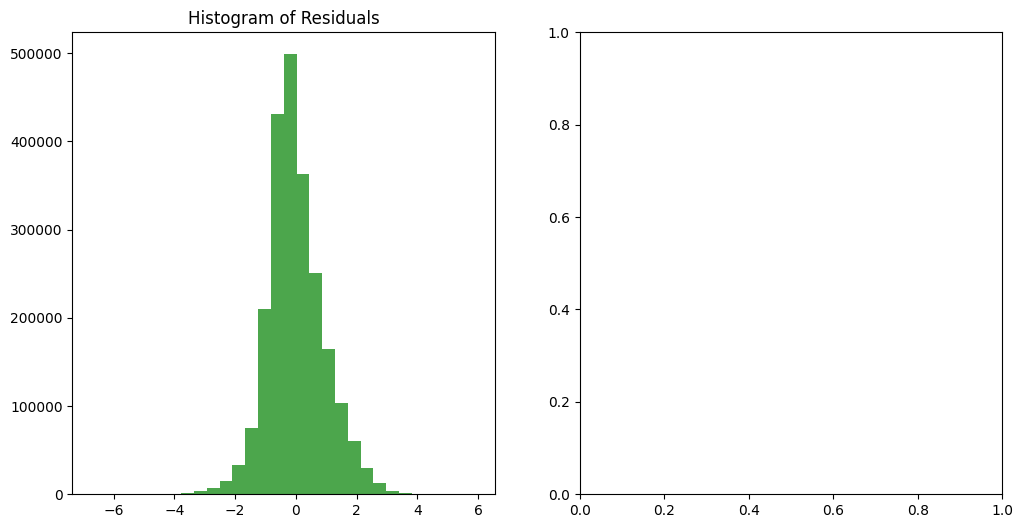

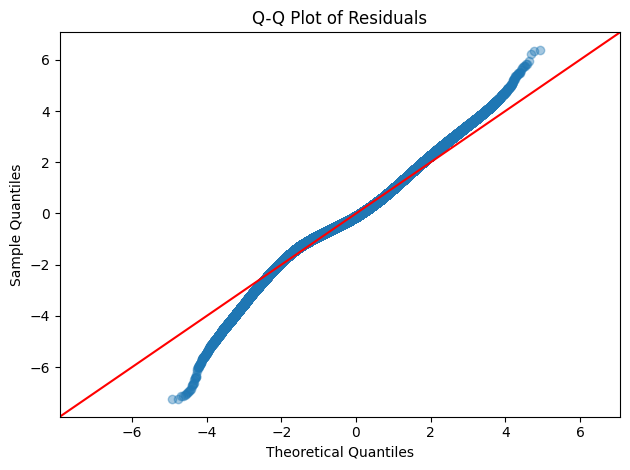

In [89]:
# Histogram of the residuals
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, alpha=0.7, color='g')
plt.title('Histogram of Residuals')

# Q-Q plot
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='45', fit=True, alpha=0.4)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

### VIF for Multicollinearity

In [90]:
def calculate_vif(dataframe):
    # Adding a constant column for intercept in VIF calculation
    df = add_constant(dataframe)
    
    # Calculating VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    
    return vif_data

In [91]:
print(calculate_vif(X_removed))

                       Feature        VIF
0                        const  12.342089
1                     watchers   1.347565
2                  diskUsageKb   1.275233
3                 pullRequests   1.906433
4     defaultBranchCommitCount   2.143232
5                          age   1.620762
6            primaryLanguage_C   1.057765
7           primaryLanguage_C#   1.055798
8          primaryLanguage_C++   1.075671
9         primaryLanguage_HTML   1.049143
10        primaryLanguage_Java   1.097045
11  primaryLanguage_JavaScript   1.183365
12         primaryLanguage_PHP   1.058381
13      primaryLanguage_Python   1.188921
14  primaryLanguage_TypeScript   1.064468


## Testing Models on Target Features before Framework Test

### Linear Regression

Stars

In [118]:
train_evaluate_explain(stars_input,y_star)


Average of y: 2.979553150744714
Model Intercept: 1.3532342229123195
watchers: 0.8514251630977661
diskUsageKb: 0.02003282891563235
pullRequests: 0.09724785845616495
defaultBranchCommitCount: -0.010459470047112722
age: 0.08692598391514653
primaryLanguage_C: -0.006968172091492473
primaryLanguage_C#: -0.01450095987689262
primaryLanguage_C++: 0.0032493041504801064
primaryLanguage_HTML: -0.08791448311456869
primaryLanguage_Java: -0.042695252627602
primaryLanguage_JavaScript: -0.037172657115022954
primaryLanguage_PHP: -0.1101709243944689
primaryLanguage_Python: 0.03918001548712698
primaryLanguage_TypeScript: 0.14399068321736425
Test Set - MSE: 0.8583, R^2: 0.4438, MAE: 0.7108



LinearExplainer explainer: 566879it [00:18, 6512.91it/s]                                                               


Forks

In [119]:
train_evaluate_explain(forks_input,y_fork)


Average of y: 1.7503364114891986
Model Intercept: 0.05711188042797222
watchers: 0.8416469703722551
diskUsageKb: 0.044514554554103414
pullRequests: 0.15814150161878093
defaultBranchCommitCount: -0.08437920823895512
age: 0.2114050973671484
primaryLanguage_C: 0.0031048508401468763
primaryLanguage_C#: 0.0007361701570946452
primaryLanguage_C++: 0.010744751362617336
primaryLanguage_HTML: -0.06211395735940542
primaryLanguage_Java: -0.0106940476518083
primaryLanguage_JavaScript: -0.014772581807889061
primaryLanguage_PHP: -0.056051480540471044
primaryLanguage_Python: 0.02055768329925741
primaryLanguage_TypeScript: 0.060471966673113074
Test Set - MSE: 0.9786, R^2: 0.4501, MAE: 0.7832



LinearExplainer explainer: 566879it [00:15, 12809.63it/s]                                                              


Issues

In [12]:
train_evaluate_explain(issues_input,y_issue)


Average of y: 1.1259304838976931
Model Intercept: -0.6752913401439005
watchers: 0.4487939913347057
diskUsageKb: 0.00188394908095324
pullRequests: 0.3455639382856565
defaultBranchCommitCount: 0.1514493735674612
age: 0.09485762791050281
primaryLanguage_C: -0.023534068196621977
primaryLanguage_C#: 0.10890804759842436
primaryLanguage_C++: 0.093994156806286
primaryLanguage_HTML: -0.0714720884656853
primaryLanguage_Java: 0.06578169959037154
primaryLanguage_JavaScript: 0.040411374489634
primaryLanguage_PHP: 0.09589757563559295
primaryLanguage_Python: 0.18485528513713043
primaryLanguage_TypeScript: 0.009413140049024066
Test Set - MSE: 0.9694, R^2: 0.5075, MAE: 0.7392



LinearExplainer explainer: 567958it [00:12, 8148.27it/s]                                                               


## Model Robust Framework Pipeline

### Baseline

Stars

In [48]:
seeds = np.random.randint(20, 33, 10)
summary = model_baseline_framework(stars_input, y_star, seeds, pdf_path='[2nd-dataset]baseline_eval_stars')
print(summary)

{'MSE': {'mean': 1.7224572019040363, '95%_CI': (1.7144559726167443, 1.727983347184486)}, 'RMSE': {'mean': 1.3124228329358083, '95%_CI': (1.3093723582758054, 1.314527682909574)}, 'MAE': {'mean': 0.8916893626247437, '95%_CI': (0.8895517600603847, 0.8926869813124281)}, 'R_squared': {'mean': -0.10949242790925857, '95%_CI': (-0.1103066835167088, -0.10847051070365832)}}


Forks

In [49]:
seeds = np.random.randint(20, 33, 10)
summary = model_baseline_framework(forks_input, y_fork, seeds, pdf_path='[2nd-dataset]baseline_eval_forks')
print(summary)

{'MSE': {'mean': 1.8016777429541797, '95%_CI': (1.796173519879448, 1.8082307700659341)}, 'RMSE': {'mean': 1.342264998453739, '95%_CI': (1.3402139828696937, 1.3447046365074147)}, 'MAE': {'mean': 1.027652678832186, '95%_CI': (1.0262090356585567, 1.0292819534788662)}, 'R_squared': {'mean': -0.01087831521021263, '95%_CI': (-0.011265769005550829, -0.010651812624558037)}}


Issues

In [50]:
seeds = np.random.randint(20, 33, 10)
summary = model_baseline_framework(issues_input, y_issue, seeds, pdf_path='[2nd-dataset]baseline_eval_issues')
print(summary)

{'MSE': {'mean': 2.16161418108715, '95%_CI': (2.153302094726004, 2.1705847457387475)}, 'RMSE': {'mean': 1.470241414617672, '95%_CI': (1.4674133600309416, 1.4732903034284173)}, 'MAE': {'mean': 1.0302577012777763, '95%_CI': (1.028484345962232, 1.032125306442524)}, 'R_squared': {'mean': -0.09505373342690197, '95%_CI': (-0.09584588299837471, -0.09401814158620246)}}


### Linear Regression

Stars

In [31]:
model = LinearRegression()
seeds = np.random.randint(20, 33, 10)
summary = model_evaluation_framework(model, stars_input, y_star, seeds,\
                                    model_type='linear',pdf_path=f'[2nd-dataset]LR_stars.pdf')
print(summary)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:27<00:00,  2.73s/it]


IndexError: invalid index to scalar variable.

Forks

In [32]:
model = LinearRegression()
seeds = np.random.randint(20, 33, 10)
summary = model_evaluation_framework(model, forks_input, y_fork, seeds,\
                                    model_type='linear',pdf_path=f'[2nd-dataset]LR_forks.pdf')
print(summary)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.56s/it]


IndexError: invalid index to scalar variable.

Issues

In [33]:
model = LinearRegression()
seeds = np.random.randint(20, 33, 10)
summary = model_evaluation_framework(model, issues_input, y_issue, seeds,\
                                    model_type='linear',pdf_path=f'[2nd-dataset]LR_issues.pdf')
print(summary)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.60s/it]


IndexError: invalid index to scalar variable.

### XGBoost

Stars

In [37]:
seeds = np.random.randint(20, 33, 10)
summary = xgb_evaluation_framework(stars_input, y_star, seeds, \
                             model_type='xgboost', pdf_path=f'[2nd-dataset]xgb_eval_stars.pdf')
print(summary)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [54:36<00:00, 327.65s/it]


{'MSE': {'mean': 0.781364381980813, '95%_CI': (0.779410137042234, 0.7841640076856387)}, 'RMSE': {'mean': 0.8839478384732995, '95%_CI': (0.8828420640116018, 0.8855301561038419)}, 'MAE': {'mean': 0.6698308377389736, '95%_CI': (0.668901164771623, 0.6709528693954232)}, 'R_squared': {'mean': 0.49625913019160856, '95%_CI': (0.49504366265756417, 0.4979535306568013)}}


Forks

In [38]:
seeds = np.random.randint(20, 33, 10)
summary = xgb_evaluation_framework(forks_input, y_fork, seeds, \
                             model_type='xgboost', pdf_path=f'[2nd-dataset]xgb_eval_forks.pdf')
print(summary)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:33:18<00:00, 559.81s/it]


{'MSE': {'mean': 0.8937278006146903, '95%_CI': (0.8913670144564138, 0.8980043658311355)}, 'RMSE': {'mean': 0.9453708994751169, '95%_CI': (0.9441223496424488, 0.9476309227917457)}, 'MAE': {'mean': 0.7456482352611644, '95%_CI': (0.7447516396393266, 0.7470526675358692)}, 'R_squared': {'mean': 0.49775143232141017, '95%_CI': (0.49464759038136974, 0.49918375348328203)}}


Issues

In [39]:
seeds = np.random.randint(20, 33, 10)
summary = xgb_evaluation_framework(issues_input, y_issue, seeds, \
                             model_type='xgboost', pdf_path=f'[2nd-dataset]xgb_eval_issues.pdf')
print(summary)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [51:48<00:00, 310.88s/it]


{'MSE': {'mean': 0.8944777801435622, '95%_CI': (0.8919009249887325, 0.8974045765353673)}, 'RMSE': {'mean': 0.9457678325581762, '95%_CI': (0.9444050543729989, 0.9473143741746918)}, 'MAE': {'mean': 0.7075488661760152, '95%_CI': (0.7066997437101733, 0.7082370563754408)}, 'R_squared': {'mean': 0.5472029126452717, '95%_CI': (0.5460632526666456, 0.5488422709291407)}}
